In [41]:
import bisect
from dataclasses import dataclass, field
from typing import Tuple

import numpy as np
import scipy as sp
import sympy as sym
from hybrid_ode_sim.simulation.ode_solvers.fixed_step_solver import RK4

from hybrid_ode_sim.simulation.base import (ContinuousTimeModel,
                                            DiscreteTimeModel)
from hybrid_ode_sim.simulation.simulator import (ModelGraph,
                                                 SimulationEnvironment,
                                                 Simulator)

from hybrid_ode_sim.utils.logging_tools import LogLevel
from scipy.interpolate import interp1d
from spatialmath.base import (exp2r, q2r, qconj, qdotb, qnorm, qqmul, qslerp,
                              qunit, qvmul, r2q, skewa, skew, qeye, qrand)

import uav_control.constants as constants
from uav_control.constants import (OMEGA_B0_B, OMEGA_B0_B_DIM, Q_NB, Q_NB_DIM,
                                   R_B0_N, R_B0_N_DIM, TAU_B0_B, TAU_B0_B_DIM,
                                   THRUST, THRUST_DIM, V_B0_N, V_B0_N_DIM,
                                   a_g_N, compose_state, compose_state_dot,
                                   decompose_control, decompose_state, e3,
                                   thrust_axis_B)
from uav_control.utils.math import (compute_cross_product_dot,
                                    compute_unit_vector_ddot,
                                    compute_unit_vector_dot, dxu_dx_jacobian,
                                    sym_Aq, sym_Gq, sym_H, sym_Lq, sym_Rq,
                                    sym_skewsym, vee)

In [84]:
# Write out symbolic equations of motion for the rigid body orientation dynamics
q_err = sym.symbols('q_err:4')
omega_err = sym.symbols('omega_err:3')

q_err = sym.Matrix(q_err)
omega_err = sym.Matrix(omega_err)

q_err_dot = 1/2 * sym_Lq(q_err) @ sym_H @ omega_err
dq_err_dot__domega_err = q_err_dot.jacobian(omega_err)
dq_err_dot__dq_err = q_err_dot.jacobian(q_err)

In [73]:
Q0 = qeye()

class OrientationPlanner(DiscreteTimeModel):
    def __init__(self, y0, sample_rate, 
                 name = "orientation_planner",
                 params=qeye(),
                 logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
        self.q_prev = Q0
    
    def discrete_dynamics(self, t, y):
        q_NF = self.params[0]
        t_f = self.params[1]

        q_ND = qslerp(Q0, q_NF, min(1.0, t/t_f), shortest=True)
        
        q_dot = 1/self.sample_rate * (q_ND - self.q_prev)
        omega_d0_D = 2 * qqmul(qconj(q_ND), q_dot)[1:]
        
        self.q_prev = q_ND
        
        planner_out = np.concatenate((q_ND, omega_d0_D))
        return planner_out

@dataclass
class OrientationLQRControllerParams:
    Q: np.ndarray = np.eye(3)
    R: np.ndarray = np.eye(3)
    R_inv: np.ndarray = field(init=False)
    
    def __post_init__(self):
        self.R_inv = np.linalg.inv(self.R)

class OrientationLQRController(DiscreteTimeModel):
    def __init__(self, y0, sample_rate,
                 name="orientation_lqr_controller",
                 params=OrientationLQRControllerParams(),
                 logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
    
    @staticmethod
    def _q_err_shortest(qd, q):
        q_err = qqmul(qconj(qd), q)
        if q_err[0] < 0:
            q_err = -q_err
        return q_err
    
    def discrete_dynamics(self, t, y):
        # Vector part of the quaternion is the state, angular velocity is the control
        x_curr = self.input_models["rigid_body_orientation_dynamics"].y
        x_des = self.input_models["orientation_planner"].y
        
        q_NB, omega_b0_B = x_curr[0:Q_NB_DIM], self.y
        q_ND, omega_d0_D = x_des[0:Q_NB_DIM], x_des[Q_NB_DIM:]
        
        q_BD = qqmul(qconj(q_NB), q_ND)
        omega_d0_B = qvmul(q_BD, omega_d0_D)
        
        q_err = self._q_err_shortest(q_ND, q_NB)
        q_err_vec = q_err[1:]
        omega_err = omega_b0_B - omega_d0_B
        
        # A matrix
        dq_err_dot__dq_err = -1/2 * skew(omega_err)
        A = dq_err_dot__dq_err

        # B matrix
        dq_err_dot__domega_err = 1/2 * (q_err[0] * np.eye(3) + skew(q_err[1:]))
        B = dq_err_dot__domega_err
        
        P = sp.linalg.solve_continuous_are(A, B, self.params.Q, self.params.R)
        K = self.params.R_inv @ B.T @ P
        
        # delta u = -K * delta_x
        delta_u = -K @ q_err_vec
        u = delta_u + omega_d0_B
                
        return u


class BodyrateController(DiscreteTimeModel):
    def __init__(self, y0, sample_rate, name="bodyrate_controller", params=None, logging_level=LogLevel.ERROR):
        super().__init__(y0, sample_rate, name, params, logging_level)
    
    def discrete_dynamics(self, t, y):
        omega_d0_B = self.input_models["orientation_lqr_controller"].y
        omega_b0_B = self.input_models["rigid_body_orientation_dynamics"].y[Q_NB_DIM:]
        
        u = omega_d0_B - omega_b0_B
        
        return u


class RigidBodyOrientationDynamics(ContinuousTimeModel):
    def __init__(self, y0, name = "rigid_body_orientation_dynamics", params=None, logging_level=LogLevel.ERROR):
        super().__init__(y0, name, params, logging_level)
    
    def output_validate(self, y: np.ndarray) -> np.ndarray:
        return y / qnorm(y)
    
    def continuous_dynamics(self, t, y):
        omega_ctrl_B = self.input_models["orientation_lqr_controller"].y
        q_NB_dot = 1/2 * qdotb(self.y, omega_ctrl_B)
        
        return q_NB_dot

In [82]:
t_range = [0, 4.0]
q_des = qrand()

planner = OrientationPlanner(y0=Q0, sample_rate=20,
                             params=(q_des, t_range[-1] - 1.0))

controller = OrientationLQRController(y0=np.zeros(3),
                                      sample_rate=20,
                                      params=OrientationLQRControllerParams(
                                          Q = np.eye(3),
                                          R = 0.001 * np.eye(3),
                                      ))

dynamics = RigidBodyOrientationDynamics(y0=Q0)

planner.inputs_to(controller)
controller.inputs_to(dynamics)
controller.feedback_from(dynamics)

model_graph = ModelGraph(
    models=[
        controller,
        dynamics,
        planner
    ]
)

# Run simulation
env = SimulationEnvironment(
    simulator=Simulator(model_graph, RK4(h=0.01))
).run_simulation(t_range=t_range)

[Simulator] INFO: Simulation Complete! Elapsed Time: 0.09 s (43.72x real-time)


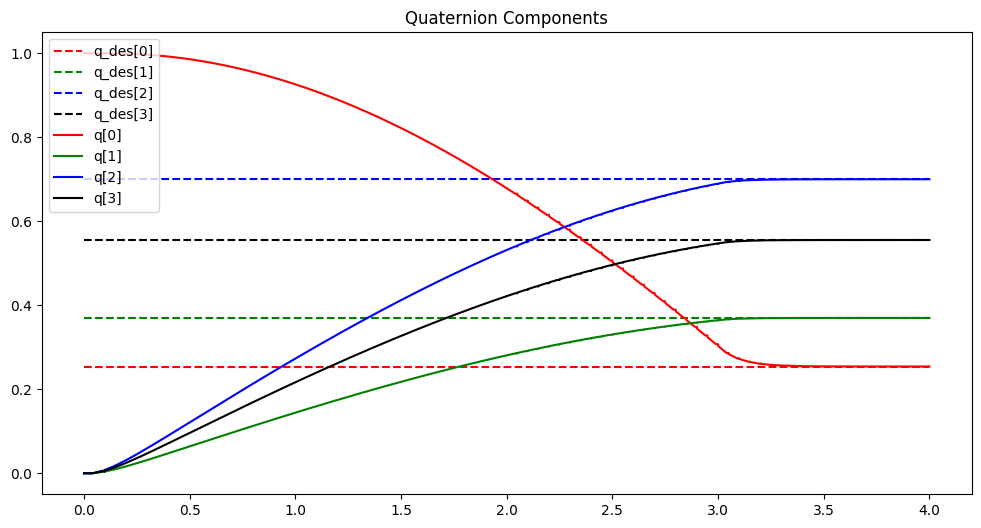

In [85]:
ts, ys, history_fn = dynamics.history()
ys = np.array(ys)

import matplotlib.pyplot as plt

# Plot the desired and actual quaternion components over time
plt.figure(figsize=(12, 6))

plt.title('Quaternion Components')

plt.plot(ts, q_des[0] * np.ones_like(ts), label='q_des[0]', color='r', linestyle='--')
plt.plot(ts, q_des[1] * np.ones_like(ts), label='q_des[1]', color='g', linestyle='--')
plt.plot(ts, q_des[2] * np.ones_like(ts), label='q_des[2]', color='b', linestyle='--')
plt.plot(ts, q_des[3] * np.ones_like(ts), label='q_des[3]', color='k', linestyle='--')

plt.plot(ts, ys[:, 0], label='q[0]', color='r')
plt.plot(ts, ys[:, 1], label='q[1]', color='g')
plt.plot(ts, ys[:, 2], label='q[2]', color='b')
plt.plot(ts, ys[:, 3], label='q[3]', color='k')

plt.legend()
plt.show()
